In [1]:
import sys
import numpy as np
import sklearn
import pandas as pd
from math import sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew
from scipy import stats
from scipy.special import boxcox1p
import warnings

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 

# add xgboost
# import xgboost as xgb

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# get the data, create dummy variables
train = pd.read_csv('data/house-prices/train.csv', index_col=['Id'])
test = pd.read_csv('data/house-prices/test.csv', index_col=['Id'])

train_dummy = pd.read_csv('data/house-prices/train.csv', index_col=['Id'])
test_dummy = pd.read_csv('data/house-prices/test.csv', index_col=['Id'])

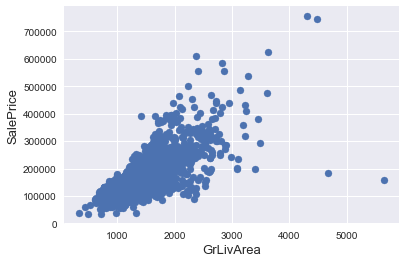

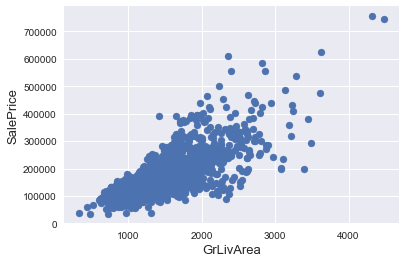

In [3]:
# check GrLivArea vs SalePrice
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# drop two outliers and draw again
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)
train_dummy.drop(train_dummy[(train_dummy["GrLivArea"]>4000)&(train_dummy["SalePrice"]<300000)].index,inplace=True)

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [4]:
# define the feature classes, each class has a different preprocessing pattern

# purely numeric features that are to stay numeric
numeric_feature_names = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                        '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
                        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea',
                        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

# numeric features that are respresented by year and are to be made categorical with slices of several years
year_features_to_make_categorical = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

# numeric features that are better presented as categorical based on the description
numeric_features_to_make_categorical = ['MSSubClass', 'OverallQual', 'OverallCond', 'YrSold', 'MoSold']

# purely categorical features that are to be label encoded
categorical_feature_names = list(
    set(train.columns) - set(numeric_feature_names) - set(year_features_to_make_categorical) - set(numeric_features_to_make_categorical))

# all categorical features that are to be one-hot encoded
all_categorical_feature_names = list(set(train.columns) - set(numeric_feature_names) - set(['SalePrice']))

# fillna with None for features where that's appropriate(e.g. NA for PoolQC means no pool) according to the documentation
features_to_impute_with_none = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'PoolQC', 'Fence',
                      'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Alley', 'MiscFeature']

In [5]:
# impute the following features with "None" instead of NA, as the description says NA means "None" and no missing value
train[features_to_impute_with_none] = train[features_to_impute_with_none].fillna("None")
test[features_to_impute_with_none] = test[features_to_impute_with_none].fillna("None")

train_dummy[features_to_impute_with_none] = train_dummy[features_to_impute_with_none].fillna("None")
test_dummy[features_to_impute_with_none] = test_dummy[features_to_impute_with_none].fillna("None")

# fill in the only missing Electrical value in both train and test
train['Electrical'] = train['Electrical'].fillna('SBrkr')
train_dummy['Electrical'] = train_dummy['Electrical'].fillna('SBrkr')

In [6]:
# change the Neighborhood feature into several classes of Neighbourhoods
# pd.options.display.max_rows = 26
# train['SalePrice'].groupby(train['Neighborhood']).mean().sort_values()
# train['SalePrice'].groupby(train['Neighborhood']).median().sort_values()
neighborhood_map = {
    'MeadowV': 0,
    'IDOTRR': 0,
    'BrDale': 0,
    'BrkSide': 1,
    'Edwards': 1,
    'OldTown': 1,
    'Sawyer': 2,
    'Blueste': 2,
    'SWISU': 3,
    'NPkVill': 3,
    'NAmes': 3,
    'Mitchel': 3,
    'SawyerW': 4,
    'NWAmes': 4,
    'Gilbert': 4,
    'Blmngtn': 4,
    'CollgCr': 4,
    'Crawfor': 5,
    'ClearCr': 5,
    'Somerst': 5,
    'Veenker': 5,
    'Timber': 5,
    'StoneBr': 6,
    'NridgHt': 6,
    'NoRidge': 6
}
def slice_neighborhoods():
    train['Neighborhood'] = train['Neighborhood'].map(neighborhood_map)
    test['Neighborhood'] = test['Neighborhood'].map(neighborhood_map)
    train_dummy['Neighborhood'] = train_dummy['Neighborhood'].map(neighborhood_map)
    test_dummy['Neighborhood'] = test_dummy['Neighborhood'].map(neighborhood_map)
    
slice_neighborhoods()

In [7]:
# change train_dummy and test_dummy and replace na with the average of the feature for numeric
# and with the most frequent category for categorical
train_dummy['MasVnrType'] = train_dummy['MasVnrType'].fillna('None')
train_dummy['MasVnrArea'] = train_dummy['MasVnrArea'].fillna(np.mean(train['MasVnrArea']))
train_dummy['GarageYrBlt'] = train_dummy['GarageYrBlt'].fillna(np.mean(train['GarageYrBlt']))
train_dummy['LotFrontage'] = train_dummy['LotFrontage'].fillna(np.mean(train['LotFrontage']))

# filling test_dummy with the averages/most frequent of the train features
test_dummy['BsmtFinSF1'] = test_dummy['BsmtFinSF1'].fillna(np.mean(train['BsmtFinSF1']))
test_dummy['GarageArea'] = test_dummy['GarageArea'].fillna(np.mean(train['GarageArea']))
test_dummy['BsmtUnfSF'] = test_dummy['BsmtUnfSF'].fillna(np.mean(train['BsmtUnfSF']))
test_dummy['BsmtFinSF2'] = test_dummy['BsmtFinSF2'].fillna(np.mean(train['BsmtFinSF2']))
test_dummy['TotalBsmtSF'] = test_dummy['TotalBsmtSF'].fillna(np.mean(train['TotalBsmtSF']))
test_dummy['MasVnrArea'] = test_dummy['MasVnrArea'].fillna(np.mean(train['MasVnrArea']))
test_dummy['LotFrontage'] = test_dummy['LotFrontage'].fillna(np.mean(train['LotFrontage']))
test_dummy['GarageYrBlt'] = test_dummy['GarageYrBlt'].fillna(5)
test_dummy['GarageCars'] = test_dummy['GarageCars'].fillna(2)
test_dummy['BsmtFullBath'] = test_dummy['BsmtFullBath'].fillna(0)
test_dummy['BsmtHalfBath'] = test_dummy['BsmtHalfBath'].fillna(0)
test_dummy['Exterior2nd'] = test_dummy['Exterior2nd'].fillna('VinylSd')
test_dummy['KitchenQual'] = test_dummy['KitchenQual'].fillna('TA')
test_dummy['Exterior1st'] = test_dummy['Exterior1st'].fillna('VinylSd')
test_dummy['SaleType'] = test_dummy['SaleType'].fillna('WD')
test_dummy['Utilities'] = test_dummy['Utilities'].fillna('AllPub')
test_dummy['Functional'] = test_dummy['Functional'].fillna('Typ')
test_dummy['MSZoning'] = test_dummy['MSZoning'].fillna('RL')
test_dummy['MasVnrType'] = test_dummy['MasVnrType'].fillna('None')
test_dummy['SalePrice'] = np.mean(train.SalePrice)

# pd.options.display.max_rows = 4
# print(train_dummy.isnull().sum().sort_values())
# print(test_dummy.isnull().sum().sort_values())

# # examples:
# train_dummy['MasVnrType'].value_counts()
# np.mean(test_dummy['GarageYrBlt'])
# test_dummy['MasVnrType'].value_counts()

In [8]:
# create lists of different type of features to impute
numeric_vals_to_impute = ['BsmtFinSF1', 'GarageArea', 'BsmtUnfSF', 'BsmtFinSF2', 'TotalBsmtSF', 'MasVnrArea', 'LotFrontage',
                         'GarageCars', 'BsmtFullBath', 'BsmtHalfBath']

numeric_vals_to_impute_rounded = ['GarageCars', 'BsmtFullBath', 'BsmtHalfBath']

categorical_vals_to_impute = ['Exterior2nd', 'KitchenQual', 'Exterior1st', 'SaleType', 'Utilities', 'Functional',
                              'MSZoning', 'MasVnrType']

all_values_to_impute = ['BsmtFinSF1', 'GarageArea', 'BsmtUnfSF', 'BsmtFinSF2', 'TotalBsmtSF', 'MasVnrArea', 'LotFrontage',
                         'GarageYrBlt', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath', 'Exterior2nd', 'KitchenQual',
                        'Exterior1st', 'SaleType', 'Utilities', 'Functional', 'MSZoning', 'MasVnrType']

dummy_columns = list(set(train.columns) - set(numeric_feature_names) - set(['SalePrice']))
non_dummy_columns = list(set(train.columns) - set(dummy_columns))

# print(list(dummy_columns))
# pd.options.display.max_rows = 12
# print(train[numeric_feature_names])
# print(pd.get_dummies(train[dummy_columns], columns=dummy_columns).columns)
# print(list(pd.get_dummies(train[dummy_columns], columns=dummy_columns).columns))
def impute_features(impute_strategy):
    for feat in numeric_vals_to_impute:
        train_predict_mask = train[feat].isnull()
        test_predict_mask = test[feat].isnull()
        if impute_strategy == "predict":
            # for each numeric feature, train Ridge with CV and based on CV score chose alpha
            alphas = [0.0001, 0.01, 0.1, 10, 100]
            scores = []
            train_dummed = pd.get_dummies(train_dummy[dummy_columns], columns=dummy_columns)
            train_data = pd.concat([train_dummy[non_dummy_columns], train_dummed], axis=1)
            test_dummed = pd.get_dummies(test_dummy[dummy_columns], columns=dummy_columns)
            test_dummed = test_dummed.reindex(columns=train_dummed.columns, fill_value=0)
            test_data = pd.concat([test_dummy[non_dummy_columns], test_dummed], axis=1)
            mask = train_data[feat].notnull()
            target = train_data[feat][mask]
            data = train_data.drop(feat, axis=1)[mask]
            for a in alphas:
                model = Ridge(alpha=a)
                a_scores = cross_val_score(model, data, target, cv=5)
                scores.append(np.mean(a_scores))
            best_alpha = alphas[np.argmax(scores)]
            # print(feat, " best alpha: ", best_alpha)
            model = Ridge(alpha=best_alpha).fit(data, target)
            if train[feat].isnull().sum() > 0:
                train[feat][train_predict_mask] = model.predict(train_data.drop(feat, axis=1)[train_predict_mask])
                if feat in numeric_vals_to_impute_rounded:
                    train[feat][train_predict_mask] = train[feat][train_predict_mask].round()
                num_data = train[feat]._get_numeric_data()
                # do not allow negative values
                num_data[num_data < 0] = 0
                # print(train[feat][train_predict_mask])
            if test[feat].isnull().sum() > 0:
                test[feat][test_predict_mask] = model.predict(test_data.drop(feat, axis=1)[test_predict_mask])
                if feat in numeric_vals_to_impute_rounded:
                    test[feat][test_predict_mask] = test[feat][test_predict_mask].round()
                num_data = test[feat]._get_numeric_data()
                num_data[num_data < 0] = 0
        elif impute_strategy == "discard":
            train[feat] = train[feat].fillna(0)
            test[feat] = test[feat].fillna(0)
        elif impute_strategy == "mean":
            if feat in numeric_vals_to_impute_rounded:
                train[feat] = train[feat].fillna(train[feat].median())
                test[feat] = test[feat].fillna(train[feat].median())
            else:
                train[feat] = train[feat].fillna(train[feat].mean())
                test[feat] = test[feat].fillna(train[feat].mean())
                
                
impute_features("predict")
# mean: 0.12270


# to be implemented
# for feat in categorical_vals_to_impute:
train['MasVnrType'] = train['MasVnrType'].fillna('None')
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(5)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(5)
test['MasVnrType'] = test['MasVnrType'].fillna('None')
test['KitchenQual'] = test['KitchenQual'].fillna('TA')
test['Exterior1st'] = test['Exterior1st'].fillna('VinylSd')
test['Exterior2nd'] = test['Exterior2nd'].fillna('VinylSd')
test['SaleType'] = test['SaleType'].fillna('WD')
test['Utilities'] = test['Utilities'].fillna('AllPub')
test['Functional'] = test['Functional'].fillna('Typ')
test['MSZoning'] = test['MSZoning'].fillna('RL')

pd.options.display.max_rows = 8
print(train.isnull().sum().sort_values())
print(test.isnull().sum().sort_values())

MSSubClass       0
GarageType       0
FireplaceQu      0
Fireplaces       0
                ..
Exterior1st      0
RoofMatl         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64
MSSubClass       0
FireplaceQu      0
Fireplaces       0
Functional       0
                ..
Exterior1st      0
RoofMatl         0
Foundation       0
SaleCondition    0
Length: 79, dtype: int64


In [9]:
# Convert several features to numerical, currently categorical

quality_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual',
                   'GarageCond']

quality_dict = {None: 0, 'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd':4, 'Ex': 5}
def convert_quality_to_numerical():
    for feature in quality_features:
        train[feature] = (train[feature].map(quality_dict)).astype(int)
        test[feature] = (test[feature].map(quality_dict)).astype(int)

bsmt_exp_dict = {None: 0, 'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
def convert_bsmt_exposure_to_numerical():
    train['BsmtExposure'] = (train['BsmtExposure'].map(bsmt_exp_dict)).astype(int)
    test['BsmtExposure'] = (test['BsmtExposure'].map(bsmt_exp_dict)).astype(int)

bsmt_fin_dict = {None: 0, 'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, "GLQ": 6}
# LwQ": 2, "Rec": 3, "BLQ": 4 have very similar distributions, maybe group them?
def convert_bmst_fin_to_numerical():
    for feature in ['BsmtFinType1', 'BsmtFinType2']:
        train[feature] = (train[feature].map(bsmt_fin_dict)).astype(int)
        test[feature] = (test[feature].map(bsmt_fin_dict)).astype(int)

functional_dict = {None: 0, 'None': 0, 'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}    
# Sal and Maj2 seem strange on a boxplot, maybe make three classes?
def convert_functional_to_numerical():
    train['Functional'] = train['Functional'].map(functional_dict).astype(int)
    test['Functional'] = test['Functional'].map(functional_dict).astype(int)
   

garage_fin_dict = {None: 0, 'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
# looks like a good linear relationship
def convert_garage_fin_to_numerical():
    train['GarageFinish'] = train['GarageFinish'].map(garage_fin_dict).astype(int)
    test['GarageFinish'] = test['GarageFinish'].map(garage_fin_dict).astype(int)
        

fense_dict = {None: 0, 'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4}
def convert_fense_to_numerical():
    train['Fence'] = (train['Fence'].map(fense_dict)).astype(int)
    test['Fence'] = (test['Fence'].map(fense_dict)).astype(int)
    

# converting feats to numerical and feature engineering: 0.12704
def convert_feats_to_numeric():
    convert_quality_to_numerical()
    convert_bsmt_exposure_to_numerical()
    convert_bmst_fin_to_numerical()
    convert_functional_to_numerical()
    convert_garage_fin_to_numerical()
    convert_fense_to_numerical()


# convert_feats_to_numeric()
# numeric_feature_names += quality_features
# all_categorical_feature_names = list(set(train.columns) - set(numeric_feature_names) - set(['SalePrice']))

In [11]:
# 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual','GarageCond'
pd.options.display.max_rows = 12
# test['TimeSinceSold'].value_counts()

In [12]:
# feature engineering
# 0.12572
numeric_feature_names += ['TotalSF', 'AreaOverallQual', 'TotalBaths', 'TotalArea', 'TotalArea1st2nd']

all_categorical_feature_names += ['HasBsmt', 'IsRegularLotShape', 'IsLandLevel','IsLandSlopeGtl', 'IsElectricalSBrkr',
                            'IsGarageDetached', 'IsPavedDrive', 'Remodeled', 'JustRemodeled', 'RecentRemodel',
                            'JustBuilt', 'TimeSinceSold', 'NewHouse', 'Has2ndFloor', 'HasMasVnr','HasWoodDeck',
                            'HasOpenPorch', 'HasEnclosedPorch', 'Has3SsnPorch', 'HasScreenPorch', 'HighSeazonSold',
                            'BadHeating', 'SaleConditionPriceDown', 'SeasonSold'] # 'Age',

print(numeric_feature_names)
datasets = [train, test, train_dummy, test_dummy]
for dataset in datasets:
    # create new features
    dataset['TotalSF'] = dataset['TotalBsmtSF'] + dataset['1stFlrSF'] + dataset['2ndFlrSF']
    dataset['AreaOverallQual'] = dataset['TotalSF'] * dataset['OverallQual']
    dataset['HasBsmt']= pd.Series(len(dataset['TotalBsmtSF']), index=dataset.index)
    dataset['HasBsmt'] = 0
    dataset.loc[dataset['TotalBsmtSF'] > 0, 'HasBsmt'] = 1
    dataset['IsRegularLotShape'] = (dataset['LotShape'] == 'Reg') * 1
    dataset['IsLandLevel'] = (dataset['LandContour'] == 'Lvl') * 1
    dataset['IsLandSlopeGtl'] = (dataset['LandSlope'] == 'Gtl') * 1
    dataset['IsElectricalSBrkr'] = (dataset['Electrical'] == 'SBrkr') * 1
    dataset['IsGarageDetached'] = (dataset['GarageType'] == 'Detchd') * 1
    dataset['IsPavedDrive'] = (dataset['PavedDrive'] == 'Y') * 1
    dataset['Remodeled'] = (dataset['YearRemodAdd'] != dataset['YearBuilt']) * 1
    dataset['JustRemodeled'] = (dataset['YearRemodAdd'] == dataset['YrSold']) * 1
    dataset['RecentRemodel'] = (dataset['YearRemodAdd'] + 6 > dataset['YrSold']) * 1
    dataset['JustBuilt'] = (dataset['YearBuilt'] == dataset['YrSold']) * 1
    # dataset['Age'] = 2010 - dataset['YearBuilt'] # we already have that information in the binning of YearBuilt
    dataset['TimeSinceSold'] = 2010 - dataset['YrSold']
    dataset['NewHouse'] = (dataset['YearBuilt'] + 6 > dataset['YrSold']) * 1
    dataset['Has2ndFloor'] = (dataset['2ndFlrSF'] == 0) * 1
    dataset['HasMasVnr'] = (dataset['MasVnrArea'] == 0) * 1
    dataset['HasWoodDeck'] = (dataset['WoodDeckSF'] == 0) * 1
    dataset['HasOpenPorch'] = (dataset['OpenPorchSF'] == 0) * 1
    dataset['HasEnclosedPorch'] = (dataset['EnclosedPorch'] == 0) * 1
    dataset['Has3SsnPorch'] = (dataset['3SsnPorch'] == 0) * 1
    dataset['HasScreenPorch'] = (dataset['ScreenPorch'] == 0) * 1
    dataset['HighSeazonSold'] = (dataset['MoSold'].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}))
    dataset['TotalBaths'] = (dataset['BsmtFullBath'] + dataset['BsmtHalfBath']/2 + dataset['BsmtFullBath'] + dataset['HalfBath']/2)
    # up to here: 0.12243
    dataset['BadHeating'] = dataset['HeatingQC'].replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})
    dataset['SaleConditionPriceDown'] = dataset['SaleCondition'].replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})
    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
    dataset['TotalArea'] = dataset[area_cols].sum(axis=1)
    dataset['TotalArea1st2nd'] = dataset['1stFlrSF'] + dataset['2ndFlrSF']
    dataset['SeasonSold'] = dataset['MoSold'].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    # up to here: 0.12144
    # transform features
    simple_qual_dict = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 2, 7: 2, 8: 3, 9: 3, 10: 3}
    dataset['OverallQual'] = dataset['OverallQual'].replace(simple_qual_dict)
    dataset['OverallCond'] = dataset['OverallCond'].replace(simple_qual_dict)
    dataset['Functional'] = dataset['Functional'].replace({'Min1' : 'Min', 'Min2' : 'Min', 'Mod': 'Maj', 'Maj2': 'Maj', 'Maj1': 'Maj', 'Sev': 'Maj', 'Sal': 'Maj'})
    # up to here: 0.12243
    
    
# log transform variables
for dataset in datasets:
    dataset['GrLivArea'] = np.log(dataset['GrLivArea'])
    dataset.loc[dataset['HasBsmt']==1, 'TotalBsmtSF'] = np.log(dataset['TotalBsmtSF'])

# sns.distplot(train['GrLivArea'], fit=norm)
# fig = plt.figure()
# res = stats.probplot(train['GrLivArea'], plot=plt)

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'TotalSF', 'AreaOverallQual', 'TotalBaths', 'TotalArea', 'TotalArea1st2nd']


In [13]:
train['Functional'].value_counts()

Typ    1358
Min      65
Maj      35
Name: Functional, dtype: int64

In [14]:
# change the year_features_to_make_categorical from numerical year to category which represents a slice of several years
category_slicers = [1923, 1945, 1956, 1963, 1971, 1979, 1995, 2002, 2005, 2208]

for dataset in [train, test, train_dummy, test_dummy]:
    new_values = {}
    for feature_name in year_features_to_make_categorical:    
        new_values[feature_name] = []
        for feature_value in dataset[feature_name]:
            for slicer in category_slicers:
                if slicer < feature_value:
                    pass
                else:
                    new_values[feature_name].append(category_slicers.index(slicer))
                    break
        dataset[feature_name] = new_values[feature_name]

In [15]:
# assign X and y
X = train.drop(labels=['SalePrice'], axis=1)
y = train['SalePrice']

# one-hot-encode all categorical features
X_train_dummed = pd.get_dummies(X[all_categorical_feature_names], columns=all_categorical_feature_names)
X_train = pd.concat([X[numeric_feature_names], X_train_dummed], axis=1)
X_test_dummed = pd.get_dummies(test[all_categorical_feature_names], columns=all_categorical_feature_names)
X_test_dummed = X_test_dummed.reindex(columns=X_train_dummed.columns, fill_value=0)
X_test = pd.concat([test[numeric_feature_names], X_test_dummed], axis=1)

# print("X_train.shape", X_train.shape)
# print(list(X_train.columns))
# print("X_test.shape", X_test.shape)
# print(list(X_test.columns))

In [16]:
# boxcox transform skewed features
skewed_feats = train[numeric_feature_names].apply(lambda x: skew(x)).sort_values(ascending=False)
print("Skew in numerical features:")
skewness = pd.DataFrame({'Skew' :skewed_feats})
pd.options.display.max_rows = 51
skewness.head(50)

Skew in numerical features:


Skew
MiscVal          24.434913
PoolArea         15.932532
LotArea          12.560986
TotalArea        10.892913
3SsnPorch        10.286510
LowQualFinSF      8.995688
KitchenAbvGr      4.480268
BsmtFinSF2        4.247550
ScreenPorch       4.114690
BsmtHalfBath      4.095895
EnclosedPorch     3.083987
MasVnrArea        2.690426
OpenPorchSF       2.337421
WoodDeckSF        1.544214
LotFrontage       1.537498
AreaOverallQual   1.391617
TotalArea1st2nd   0.956339
BsmtUnfSF         0.919955
1stFlrSF          0.886723
2ndFlrSF          0.812121
TotalSF           0.803494
BsmtFinSF1        0.764002
HalfBath          0.679351
TotRmsAbvGrd      0.659822
Fireplaces        0.631409
BsmtFullBath      0.589751
TotalBaths        0.565879
BedroomAbvGr      0.212107
GarageArea        0.131612
FullBath          0.031239
GrLivArea        -0.071745
GarageCars       -0.342025
TotalBsmtSF      -5.165048

In [17]:
skewed_features = ['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF', 'KitchenAbvGr', 'BsmtFinSF2',
                   'ScreenPorch', 'BsmtHalfBath', 'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'LotFrontage',
                  'AreaOverallQual', 'TotalSF', 'WoodDeckSF', 'GrLivArea', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF',
                   'BsmtFinSF1'] # TotalBsmtSF = -5.16

pd.options.display.max_rows = 4
for feat in skewed_features:
    X_train[feat] = boxcox1p(X_train[feat], 0.15)
    X_test[feat] = boxcox1p(X_test[feat], 0.15)

In [18]:
# boxcox1p makes 2 NA features in MasVnrArea
X_train['MasVnrArea'] = X_train['MasVnrArea'].fillna(0)
print(X_train.isnull().sum().sort_values())
print(X_test.isnull().sum().sort_values())

LotFrontage            0
MSSubClass_190         0
                      ..
Exterior2nd_CmentBd    0
SeasonSold_3           0
Length: 397, dtype: int64
LotFrontage            0
MSSubClass_190         0
                      ..
Exterior2nd_CmentBd    0
SeasonSold_3           0
Length: 397, dtype: int64


In [19]:
# standard scaller for numeric features
sscaler = StandardScaler().fit(X_train)
X_train_sscaled = sscaler.transform(X_train)
X_test_sscaled = sscaler.transform(X_test)

rscaler = RobustScaler().fit(X_train)
X_train_rscaled = rscaler.transform(X_train)
X_test_rscaled = rscaler.transform(X_test)

# standard scaller with lasso, ridge, elastic_net uniform, boxcox for skewed features, predicted NAs: 0.13325
# 

In [20]:
# log transform of SalePrice
y = np.log10(y)
print(y)

Id
1       5.319106
2       5.258877
          ...   
1459    5.152670
1460    5.168792
Name: SalePrice, Length: 1458, dtype: float64


In [21]:
# make models
alphas = [0.00001, 0.0001, 0.0003, 0.0005, 0.00075, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1, 10, 30, 50, 100]

print("Ridge")
train_scores = []
test_scores = []
for alpha in alphas:
    a_scores = cross_validate(Ridge(alpha=alpha, random_state=4330), X_train, y, cv=5, scoring=make_scorer(mean_squared_error))
    train_scores.append(np.mean(a_scores['train_score']))
    test_scores.append(np.mean(a_scores['test_score']))
best_alpha = alphas[np.argmin(test_scores)]
print('best train score:', sqrt(train_scores[np.argmin(train_scores)]))
print('best test score:', sqrt(test_scores[np.argmin(test_scores)]))
print('best_alpha:', best_alpha)
ridge = Ridge(alpha=best_alpha, random_state=433).fit(X_train, y)


print("Lasso")
train_scores = []
test_scores = []
for alpha in alphas:
    a_scores = cross_validate(Lasso(alpha=alpha, random_state=4330), X_train, y, cv=5, scoring=make_scorer(mean_squared_error))
    train_scores.append(np.mean(a_scores['train_score']))
    test_scores.append(np.mean(a_scores['test_score']))
best_alpha = alphas[np.argmin(test_scores)]
print('best train score:', sqrt(train_scores[np.argmin(train_scores)]))
print('best test score:', sqrt(test_scores[np.argmin(test_scores)]))
print('best_alpha:', best_alpha)
lasso = Lasso(alpha=best_alpha, random_state=433).fit(X_train, y)
# Your submission scored 0.12847

print("ElasticNet")
train_scores = []
test_scores = []
for alpha in alphas:
    a_scores = cross_validate(ElasticNet(alpha=alpha, l1_ratio=.95, random_state=4330),
                               X_train, y, cv=5, scoring=make_scorer(mean_squared_error))
    train_scores.append(np.mean(a_scores['train_score']))
    test_scores.append(np.mean(a_scores['test_score']))
best_alpha = alphas[np.argmin(test_scores)]
print('best train score:', sqrt(train_scores[np.argmin(train_scores)]))
print('best test score:', sqrt(test_scores[np.argmin(test_scores)]))
print('best_alpha:', best_alpha)
elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=0.95, random_state=433).fit(X_train, y)
# Your submission scored 0.12808
# Your submission scored 0.12887, using boxcox1p

print("KernelRidge")
train_scores = []
test_scores = []
for alpha in alphas:
    a_scores = cross_validate(KernelRidge(alpha=alpha),
                               X_train, y, cv=5, scoring=make_scorer(mean_squared_error))
    train_scores.append(np.mean(a_scores['train_score']))
    test_scores.append(np.mean(a_scores['test_score']))
best_alpha = alphas[np.argmin(test_scores)]
print('best train score:', sqrt(train_scores[np.argmin(train_scores)]))
print('best test score:', sqrt(test_scores[np.argmin(test_scores)]))
print('best_alpha:', best_alpha)
kernel_ridge = KernelRidge(alpha=best_alpha).fit(X_train, y)
# Your submission scored 0.13240

# p
# Ridge
# best test score: 0.05149482800749468
# best_alpha: 10
# Lasso
# best test score: 0.05070276768531303
# best_alpha: 0.0001
# ElasticNet
# best test score: 0.05078316658740442
# best_alpha: 0.0001
# KernelRidge
# best test score: 0.059117741535044316
# best_alpha: 0.1

# Ridge
# best train score: 0.036866066952082645
# best test score: 0.054043040250535586
# best_alpha: 100
# Lasso
# best train score: 0.03686614047840392
# best test score: 0.0506661854529501
# best_alpha: 0.001
# ElasticNet
# best train score: 0.03686613474025961
# best test score: 0.05073479086471646
# best_alpha: 0.001
# KernelRidge
# best train score: 0.03686606660084973
# best test score: 13.305459234509943
# best_alpha: 100

print("GradientBoostingRegressor")
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=4330).fit(X_train, y)
# Your submission scored 0.13189


# xgb_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state=4330, nthread=-1).fit(X_train, y)
# regr = xgb.XGBRegressor(
#                  colsample_bytree=0.2,
#                  gamma=0.0,
#                  learning_rate=0.01,
#                  max_depth=4,
#                  min_child_weight=1.5,
#                  n_estimators=7200,                                                                  
#                  reg_alpha=0.9,
#                  reg_lambda=0.6,
#                  subsample=0.2,
#                  seed=42,
#                  silent=1)

# use RobustScaler
# robust_scaler = RobustScaler()
# Xtrain_robust_scalled = robust_scaler.fit_transform(X_train)
# Xtest_robust_scalled = robust_scaler.transform(X_test)


Ridge
best train score: 0.03710147177815461
best test score: 0.05044922232250644
best_alpha: 30
Lasso
best train score: 0.03741135454229675
best test score: 0.04921109225659106
best_alpha: 0.0003
ElasticNet
best train score: 0.037394051319375524
best test score: 0.049191038934579524
best_alpha: 0.0003
KernelRidge
best train score: 0.03710493988298513
best test score: 0.05535682704115663
best_alpha: 1
GradientBoostingRegressor


In [ ]:
pd.options.display.max_rows = 12
pd.DataFrame({"Feature Importance":lasso.coef_}, index=X_train.columns).sort_values("Feature Importance",ascending=False)

In [ ]:
list(X_train.columns)

In [ ]:
predictions = (
    5*(10**lasso.predict(X_test)) + 4*(10**ridge.predict(X_test)) + 4*(10**kernel_ridge.predict(X_test)) + 3*(10**elastic_net.predict(X_test_scalled)) + 3*(10**GBoost.predict(X_test_scalled)))/19
predictions_df = pd.DataFrame({"Id":test.index, "SalePrice":predictions})
predictions_df.to_csv("submit_me.csv", index=False)
predictions_df.head()

# 5*(10**lasso.predict(X_test)) + 4*(10**ridge.predict(X_test)) + 4*(10**kernel_ridge.predict(X_test)) + 3*(10**elastic_net.predict(X_test)) + 3*(10**GBoost.predict(X_test)))/19
# imputing features with preditions: 0.12920
# imputing features with 0: 0.12920
# imputing features with predictions and making neighborhood slices: 0.12778

In [22]:
predictions = (
    10**lasso.predict(X_test) + 10**ridge.predict(X_test) + 10**elastic_net.predict(X_test))/3
predictions_df = pd.DataFrame({"Id":test.index, "SalePrice":predictions})
predictions_df.to_csv("submit_me.csv", index=False)
predictions_df.head()
# standard scaller with lasso, ridge, elastic_net uniform: 0.12778

Id      SalePrice
0   1461  123303.974253
1   1462  159833.823476
..   ...            ...
3   1464  201446.823196
4   1465  195506.795323

[5 rows x 2 columns]

In [ ]:
list(X_train.columns)

In [ ]:
# # pure Ridge
# predictions = ((10**ridge.predict(X_test)))
# predictions_df = pd.DataFrame({"Id":test.index, "SalePrice":predictions})
# predictions_df.to_csv("submit_me.csv", index=False)
# print(predictions_df.head())
# # Your submission scored 0.12612

# # pure Lasso
# predictions = ((10**lasso.predict(X_test)))
# predictions_df = pd.DataFrame({"Id":test.index, "SalePrice":predictions})
# predictions_df.to_csv("submit_me.csv", index=False)
# print(predictions_df.head())
# # Your submission scored 0.12787

# # pure KernelRidge
# predictions = ((10**kernel_ridge.predict(X_test)))
# predictions_df = pd.DataFrame({"Id":test.index, "SalePrice":predictions})
# predictions_df.to_csv("submit_me.csv", index=False)
# print(predictions_df.head())
# # Your submission scored 0.12870

# # pure ElasticNet
# predictions = ((10**elastic_net.predict(X_test)))
# predictions_df = pd.DataFrame({"Id":test.index, "SalePrice":predictions})
# predictions_df.to_csv("submit_me.csv", index=False)
# predictions_df.head()
# # Your submission scored 0.13027

# # pure GBoost
# predictions = ((10**GBoost.predict(X_test)))
# predictions_df = pd.DataFrame({"Id":test.index, "SalePrice":predictions})
# predictions_df.to_csv("submit_me.csv", index=False)
# predictions_df.head()
# # Your submission scored 0.13010

In [ ]:
print("Ridge")
scores = []
for alpha in alphas:
    a_scores = cross_val_score(Ridge(alpha=alpha), X_train, y, cv=5, scoring=make_scorer(mean_squared_error))
    scores.append(np.mean(a_scores))
best_alpha = alphas[np.argmin(scores)]
print('best_alpha Ridge:', best_alpha)
ridge = Ridge(alpha=best_alpha).fit(X_train, y)
print(ridge)

print("Lasso")
scores = []
for alpha in alphas:
    a_scores = cross_val_score(Lasso(alpha=alpha), X_train, y, cv=5, scoring=make_scorer(mean_squared_error))
    scores.append(np.mean(a_scores))
best_alpha = alphas[np.argmin(scores)]
print('best_alpha Lasso:', best_alpha)
lasso = Lasso(alpha=best_alpha).fit(X_train, y)
print(lasso)
# 0.12808

predictions = ((10**lasso.predict(X_test)) + (10**ridge.predict(X_test)))/2
predictions_df = pd.DataFrame({"Id":test.index, "SalePrice":predictions})
predictions_df.to_csv("submit_me.csv", index=False)
predictions_df.head()

In [ ]:
# Since we need to predict SalePrice, lets see distribution and probability plots
sns.distplot(train['SalePrice']);
fig = plt.figure()
stats.probplot(train['SalePrice'], plot=plt);

In [ ]:
# transform SalePrice with logarithmic transformation and plot the distribution and the probability plots again
train['SalePrice'] = np.log10(train['SalePrice'])
sns.distplot(train['SalePrice']);
fig = plt.figure()
stats.probplot(train['SalePrice'], plot=plt);

In [ ]:
sns.distplot(train['2ndFlrSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['2ndFlrSF'], plot=plt)

In [ ]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(corrmat, vmax=.8, square=True);


In [ ]:
#saleprice correlation matrix
k = 12 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
# explore different features with relation to SalePrice
var = 'Neighborhood'
num = 2000
fig ,ax = plt.subplots()
# [train[var] < num]
ax.scatter(x=train[var][train[var] < num], y=train['SalePrice'][train[var] < num])
plt.xlabel(var)
plt.ylabel('SalePrice')
plt.show()

In [ ]:
# box plot different categorical features with relation to SalePrice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=500000);

In [ ]:
train['OverallQual'].value_counts()

In [ ]:
var = np.log(np.array([1,2,3,4,5,6,7,8,9,10]))
fig ,ax = plt.subplots()
# [train[var] < num]
ax.scatter(x=list(range(1,11)), y=var)
plt.xlabel(var)
plt.ylabel('SalePrice')
plt.show()